# Importing Required Libraries

In [3]:
#from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
#import coremltools
from scipy import stats
#from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils



# Loading the dataset

In [4]:
df=pd.read_csv('output.csv')

In [5]:
df.dropna(axis=0,inplace=True) # Removing the rows that contains NAN values

In [6]:
df.reset_index() # Reset the indices 

,index,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Position
0,1,-0.02,-0.01,0.96,2.20,1.89,0.24,33.74,-0.96,-37.29,Supine\r\r\n
1,3,-0.02,0.00,0.96,2.26,1.53,0.24,33.14,-1.25,-36.69,Supine\r\r\n
2,5,-0.02,-0.01,0.96,2.14,1.77,0.18,33.39,-1.04,-37.78,Supine\r\r\n
3,7,-0.02,0.00,0.96,2.01,1.65,0.31,33.63,-1.56,-36.33,Supine\r\r\n
4,9,-0.02,-0.01,0.96,2.32,1.71,0.37,33.36,-0.83,-37.07,Supine\r\r\n
...,...,...,...,...,...,...,...,...,...,...,...
28676,57354,0.00,-0.01,0.96,2.38,1.65,0.18,19.93,-4.54,6.70,Supine\r\r\n
28677,57356,-0.01,-0.01,0.96,2.38,1.59,0.00,20.04,-5.35,6.49,Supine\r\r\n
28678,57358,0.00,0.00,0.96,2.32,1.59,0.00,19.73,-5.52,8.07,Supine\r\r\n
28679,57360,0.00,0.00,0.96,2.38,1.65,0.06,20.74,-5.05,6.69,Supine\r\r\n


In [7]:
df['Position'] = df['Position'].map(lambda x: x.rstrip('\r\r\n'))
c1=df.Position.astype('str')

In [8]:
x=np.concatenate((df.Accelerometer_x.values,df.Gyroscope_x.values,df.Magnetometer_x.values))
y=np.concatenate((df.Accelerometer_y.values,df.Gyroscope_y.values,df.Magnetometer_y.values))
z=np.concatenate((df.Accelerometer_z.values,df.Gyroscope_z.values,df.Magnetometer_z.values))
df5=pd.concat([c1,c1,c1])

In [9]:
df1=pd.DataFrame([x,y,z,df5]).transpose()
df1.columns=['x','y','z','Position']

In [10]:
df1

,x,y,z,Position
0,-0.02,-0.01,0.96,Supine
1,-0.02,0.0,0.96,Supine
2,-0.02,-0.01,0.96,Supine
3,-0.02,0.0,0.96,Supine
4,-0.02,-0.01,0.96,Supine
...,...,...,...,...
86038,19.93,-4.54,6.7,Supine
86039,20.04,-5.35,6.49,Supine
86040,19.73,-5.52,8.07,Supine
86041,20.74,-5.05,6.69,Supine


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86043 entries, 0 to 86042
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   x         86043 non-null  object
 1   y         86043 non-null  object
 2   z         86043 non-null  object
 3   Position  86043 non-null  object
dtypes: object(4)
memory usage: 2.6+ MB


In [12]:
df1.isna().value_counts() # Checking whether the dataset contains NAN values

x      y      z      Position
False  False  False  False       86043
dtype: int64

In [13]:
df1.shape

(86043, 4)

# Frequency of obeservation by Activity Type

In [14]:
df1['Position'].value_counts()

Sitting    22461
Unknown    21486
Side       17220
Prone      14439
Supine     10437
Name: Position, dtype: int64

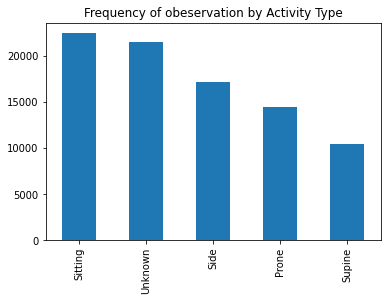

In [15]:
df1['Position'].value_counts().plot(kind='bar',title='Frequency of obeservation by Activity Type')
plt.show()

# Creating the Train and Test set

The sliding window size is 2 seconds and the sampling rate of the IMU sensor is 119HZ. So for each window, each sengment contains 2*119 = 238 of time steps.

In [16]:
# Creating a segment
time_steps=238
step=40
segments = []
labels = []
N_FEATURES=3
for i in range(0, len(df) - time_steps, step):
        xs = df1['x'].values[i: i + time_steps]
        ys = df1['y'].values[i: i + time_steps]
        zs = df1['z'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df1['Position'][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

# Bring the segments into a better shape
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
labels = np.asarray(labels)


One Hot encoding for the labels

In [17]:
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import argmax
values = array(labels)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

['Supine' 'Supine' 'Supine' 'Supine' 'Supine' 'Supine' 'Supine' 'Supine'
 'Supine' 'Supine' 'Supine' 'Supine' 'Supine' 'Side' 'Side' 'Side' 'Side'
 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side'
 'Side' 'Side' 'Side' 'Side' 'Prone' 'Prone' 'Prone' 'Prone' 'Prone'
 'Prone' 'Prone' 'Prone' 'Prone' 'Prone' 'Prone' 'Prone' 'Prone' 'Prone'
 'Prone' 'Prone' 'Prone' 'Supine' 'Supine' 'Supine' 'Supine' 'Supine'
 'Supine' 'Supine' 'Supine' 'Supine' 'Side' 'Side' 'Side' 'Side' 'Side'
 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side'
 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side' 'Side'
 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown'
 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown'
 'Unknown' 'Sitting' 'Sitting' 'Sitting' 'Sitting' 'Sitting' 'Sitting'
 'Sitting' 'Sitting' 'Sitting' 'Sitting' 'Sitting' 'Sitting' 'Sitting'
 'Sitting' 'Sitting' 'Sitting' 'Sitting' 'Sitting' 'Sitting' 'Sitting'
 

Creating Train and Test dataset with test size = 0.2

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(reshaped_segments,onehot_encoded,test_size=0.2,random_state=42)


In [19]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape # Size of training and test dataset

((569, 238, 3), (143, 238, 3), (569, 5), (143, 5))

# Neural Network

In [20]:
# 1D CNN neural network
model_m = Sequential()
model_m.add(Conv2D(32, kernel_size=(10,1), activation='relu', input_shape=(238, 3,1)))
model_m.add(Conv2D(64, kernel_size=(10,1), activation='relu'))
model_m.add(MaxPooling2D(pool_size=(2,1)))
model_m.add(Dropout(0.3))
model_m.add(Conv2D(64, kernel_size=(10,1), activation='relu'))
model_m.add(Conv2D(128, kernel_size=(10,1), activation='relu'))
model_m.add(GlobalAveragePooling2D())
model_m.add(Dropout(0.5))
model_m.add(Dense(5, activation='softmax'))
print(model_m.summary())
model_m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model_m.fit(x_train, y_train, validation_split = 0.2,epochs = 75,verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 229, 3, 32)        352       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 3, 64)        20544     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 3, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 3, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 101, 3, 64)        41024     
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 3, 128)        82048     
                                                        

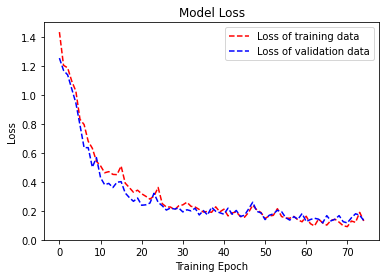

In [21]:
# Plot of Training Loss and validation Loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()



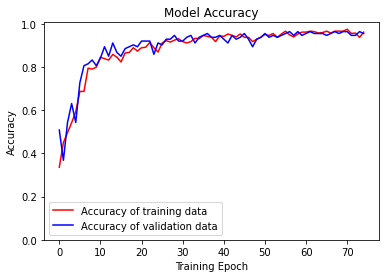

In [22]:
# Plot of Training Accuracy and validation Accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()



In [23]:
score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

5/5 [==============================] - 0s 78ms/step - loss: 0.1870 - accuracy: 0.9441

Accuracy on test data: 0.94

Loss on test data: 0.19


In [24]:
model_m.save('mymodel')

INFO:tensorflow:Assets written to: mymodel/assets


# Converting model to Tensorflow lite

In [30]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_QUANT_TFLITE = MODELS_DIR + 'model_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.h'

In [31]:
from os import write
import tensorflow as tf
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_m)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
model_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_QUANT_TFLITE, "wb").write(model_quant_tflite)

INFO:tensorflow:Assets written to: /tmp/tmpi89u66xh/assets


INFO:tensorflow:Assets written to: /tmp/tmpi89u66xh/assets


157184

In [32]:
size_quant_tflite = os.path.getsize(MODEL_QUANT_TFLITE)
size_quant_tflite

157184

In [33]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_QUANT_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_QUANT_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [34]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x28, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x5c, 0x65, 0x02, 0x00, 0x4c, 0x46, 0x02, 0x00, 0x34, 0x46, 0x02, 0x00,
  0xbc, 0x00, 0x00, 0x00, 0x84, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x40, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xbc, 0xff, 0xff, 0xff, 0x08, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x